In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from scipy.optimize import curve_fit
Z = 16

In [2]:
covid = pd.read_csv("Coronavirus_Italy.csv")

In [3]:
covid.head()

,Date,Infected,Dead,Recovered,Total
0,2/22/2020,76,2,1,79
1,2/23/2020,146,3,1,150
2,2/24/2020,221,7,1,229
3,2/25/2020,309,11,1,321
4,2/26/2020,385,12,3,400


In [4]:
covid.tail()

,Date,Infected,Dead,Recovered,Total
28,3/21/2020,42681,4825,6072,53578
29,3/22/2020,46638,5476,7024,59138
30,3/23/2020,50418,6077,7432,63927
31,3/24/2020,54030,6820,8326,69176
32,3/25/2020,57521,7503,9362,74386


In [5]:
print(covid.iloc[21])

Date         3/14/2020
Infected         17750
Dead              1441
Recovered         1966
Total            21157
Name: 21, dtype: object


In [6]:
R0=2.28
N0 = 60.48
dh = 0.05

In [7]:
def S_der(s_now, i_now, gamma, R0, N=N0):
    return -R0*gamma*i_now*s_now/N

def E_der(e_now, s_now, i_now, gamma, a_incub, R0, N=N0):
    return R0*gamma*i_now*s_now/N - a_incub*e_now

def I_der(i_now, e_now, gamma, a_incub):
    return a_incub*e_now - gamma*i_now

def R_der(r_now, i_now, gamma):
    return gamma*i_now

In [8]:
def euler(now, der_func, dh, *args):
    return now + dh*der_func(now, *args)

def midpoint(now, der_func, dh, *args):
    return now + dh*der_func(now+dh/2*der_func(now, *args), *args)

In [9]:
def pred_infected(times, gamma, a_incub, R0):
    S, E, I, R = [N0], [covid['Infected'][0]*R0/10**6], [covid['Infected'][0]/10**6], [(covid['Recovered'][0]+covid['Dead'][0])/10**6]
    integration_times = np.arange(0, times[-1]+dh, dh)
    infected = []
    for i, time in enumerate(integration_times):
        new_s = midpoint(S[i], S_der, dh, I[i], gamma, R0)
        new_e = midpoint(E[i], E_der, dh, S[i], I[i], gamma, a_incub, R0)
        new_i = midpoint(I[i], I_der, dh, E[i], gamma, a_incub)
        new_r = midpoint(R[i], R_der, dh, I[i], gamma)
        
        S.append(new_s)
        E.append(new_e)
        I.append(new_i)
        R.append(new_r)
        
        if time in times:
            infected.append(I[i])
    infected = np.array(infected)
    return infected

def pred_recovered(times, gamma, a_incub, R0):
    S, E, I, R = [N0], [covid['Infected'][0]*R0/10**6], [covid['Infected'][0]/10**6], [(covid['Recovered'][0]+covid['Dead'][0])/10**6]
    integration_times = np.arange(0, times[-1]+dh, dh)
    recovered = []
    for i, time in enumerate(integration_times):
        new_s = midpoint(S[i], S_der, dh, I[i], gamma, R0)
        new_e = midpoint(E[i], E_der, dh, S[i], I[i], gamma, a_incub, R0)
        new_i = midpoint(I[i], I_der, dh, E[i], gamma, a_incub)
        new_r = midpoint(R[i], R_der, dh, I[i], gamma)
        
        S.append(new_s)
        E.append(new_e)
        I.append(new_i)
        R.append(new_r)
        
        if time in times:
            recovered.append(R[i])
    recovered = np.array(recovered)
    return recovered

In [10]:
"""p0 = (0.02341408, 0.13668508, 18.09867843)
popt, pcov = curve_fit(pred_infected, covid.index.values[:ndx_end_fit], covid['Infected'][:ndx_end_fit]/10**6, p0=p0, maxfev=5000)
print(popt)
print("1/gamma. Typical recovery: {:.3f}".format(1/popt[0]))
print("1/a. Incubation time: {:.3f}".format(1/popt[1]))
print("R0. Reproduction number: {:.3f}".format(popt[2]))
smooth_times = np.arange(0, covid.index.values[-1], dh)
infected = pred_infected(smooth_times, *popt)
recovered = pred_recovered(smooth_times, *popt)

fig, axs = plt.subplots(figsize=(13,4), ncols=2, nrows=1)
axs[0].set_title("Infected", fontsize=Z+4)
axs[0].plot(covid.index, covid['Infected'], label="Data")
axs[0].plot(smooth_times, infected*10**6, label="Prediction")
axs[1].set_title("Recovered", fontsize=Z+4)
axs[1].plot(covid.index, covid['Recovered'], label="Data")
axs[1].plot(smooth_times, recovered*10**6, label="Prediction")
for ax in axs.flatten():
    ax.set_xlim(0,max(smooth_times))
    ax.set_xticks(np.arange(0, max(smooth_times)+1,5))
    ax.grid()
    ax.tick_params(labelsize=Z)
    ax.set_xlabel("Days from February 22", fontsize=Z)
ax.legend(fontsize=Z)
plt.show()
plt.close()"""

'p0 = (0.02341408, 0.13668508, 18.09867843)\npopt, pcov = curve_fit(pred_infected, covid.index.values[:ndx_end_fit], covid[\'Infected\'][:ndx_end_fit]/10**6, p0=p0, maxfev=5000)\nprint(popt)\nprint("1/gamma. Typical recovery: {:.3f}".format(1/popt[0]))\nprint("1/a. Incubation time: {:.3f}".format(1/popt[1]))\nprint("R0. Reproduction number: {:.3f}".format(popt[2]))\nsmooth_times = np.arange(0, covid.index.values[-1], dh)\ninfected = pred_infected(smooth_times, *popt)\nrecovered = pred_recovered(smooth_times, *popt)\n\nfig, axs = plt.subplots(figsize=(13,4), ncols=2, nrows=1)\naxs[0].set_title("Infected", fontsize=Z+4)\naxs[0].plot(covid.index, covid[\'Infected\'], label="Data")\naxs[0].plot(smooth_times, infected*10**6, label="Prediction")\naxs[1].set_title("Recovered", fontsize=Z+4)\naxs[1].plot(covid.index, covid[\'Recovered\'], label="Data")\naxs[1].plot(smooth_times, recovered*10**6, label="Prediction")\nfor ax in axs.flatten():\n    ax.set_xlim(0,max(smooth_times))\n    ax.set_xti

[1.83590463e-02 1.56405416e-01 2.08214422e+01]
1/gamma. Typical recovery: 54.469
1/a. Incubation time: 6.394
R0. Reproduction number: 20.821


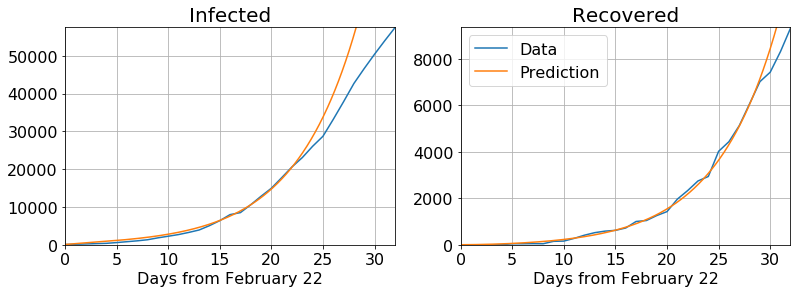

In [11]:
p0 = (0.1, 0.2, 2.2)
ndx_end_fit = 20
popt, pcov = curve_fit(pred_recovered, covid.index.values[:ndx_end_fit], covid['Recovered'][:ndx_end_fit]/10**6, p0=p0, maxfev=5000)
print(popt)
print("1/gamma. Typical recovery: {:.3f}".format(1/popt[0]))
print("1/a. Incubation time: {:.3f}".format(1/popt[1]))
print("R0. Reproduction number: {:.3f}".format(popt[2]))
smooth_times = np.arange(0, covid.index.values[-1], dh)
infected = pred_infected(smooth_times, *popt)
recovered = pred_recovered(smooth_times, *popt)

fig, axs = plt.subplots(figsize=(13,4), ncols=2, nrows=1)
axs[0].set_title("Infected", fontsize=Z+4)
axs[0].plot(covid.index, covid['Infected'], label="Data")
axs[0].plot(smooth_times, infected*10**6, label="Prediction")
axs[1].set_title("Recovered", fontsize=Z+4)
axs[1].plot(covid.index, covid['Recovered'], label="Data")
axs[1].plot(smooth_times, recovered*10**6, label="Prediction")

axs[0].set_ylim(0, max(covid['Infected']))
axs[1].set_ylim(0, max(covid['Recovered']))
for ax in axs.flatten():
    ax.set_xlim(0,max(smooth_times))
    ax.set_xticks(np.arange(0, max(smooth_times)+1,5))
    ax.grid()
    ax.tick_params(labelsize=Z)
    ax.set_xlabel("Days from February 22", fontsize=Z)
ax.legend(fontsize=Z)
plt.show()
plt.close()

In [12]:
covid.iloc[ndx_end_fit]

Date         3/13/2020
Infected         14955
Dead              1266
Recovered         1429
Total            17650
Name: 20, dtype: object

# Plots

In [13]:
covid.Date = pd.to_datetime(covid.Date)
covid.set_index('Date', inplace=True)
xfin = covid.index[-1]
xquarini = '2020-03-09'
xplus5 = '2020-03-14' #5th day from quarantine

In [14]:
covid['Infected_perc'] = covid['Infected'].pct_change()*100
covid['Dead_perc'] = covid['Dead'].pct_change()*100
covid['Recovered_perc'] = covid['Recovered'].pct_change()*100
covid['Total_perc'] = covid['Total'].pct_change()*100

In [15]:
colors = [(1.0, 0.2, 0.2), #Infected
          (0.3, 0.3, 0.3), #Dead
          (0.2, 0.7, 0.2), #Recovered
          (0.0, 0.4, 0.8)] #Total
c_span = (0.9, 0.6, 0.9)
c_5 = (0.8, 0.1, 0.8)
xticks = [t for t in covid.index if ((t.day-29)%5 == 0 and t.month == 2) or ((t.day)%5 == 0 and t.month != 2)]
xticklabels = [t.strftime('%b-%d') for t in xticks]
top_cases = 80000
print(xticklabels)

['Feb-24', 'Feb-29', 'Mar-05', 'Mar-10', 'Mar-15', 'Mar-20', 'Mar-25']


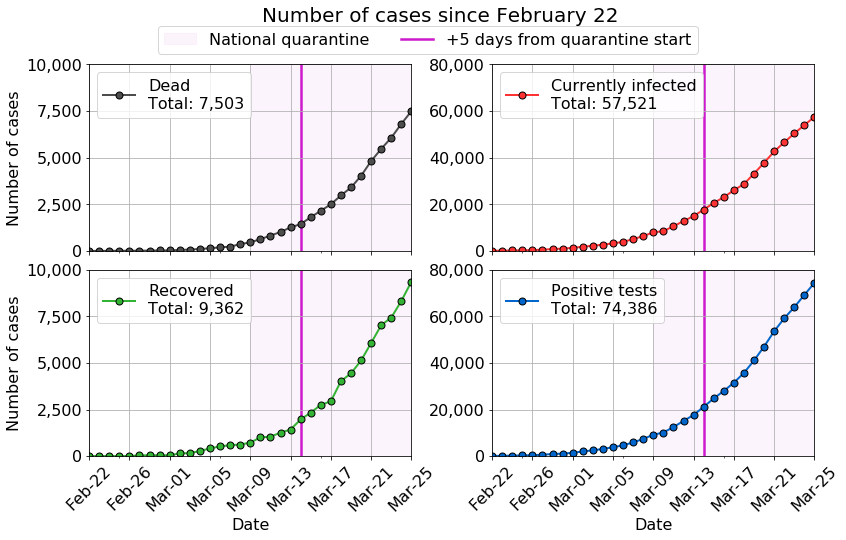

In [19]:
xini = '2020-02-22'
labels = ['Dead\nTotal: {:,}'.format(covid.Dead[-1]),
          'Currently infected\nTotal: {:,}'.format(covid.Infected[-1]),
          'Recovered\nTotal: {:,}'.format(covid.Recovered[-1]),
          'Positive tests\nTotal: {:,}'.format(covid.Total[-1])]
dates = pd.date_range(xini, xfin, freq='4D')
dateticks = [t.strftime('%b-%d') for t in dates]

fig, axs = plt.subplots(figsize=(13,8), nrows=2, ncols=2, sharex=True, sharey=False, gridspec_kw={'hspace': 0.1, 'wspace': 0.25})
covid.plot(y=['Dead'], ax=axs[0,0], grid=True, color=colors[1], marker='o', markersize=7, linewidth=2, markeredgecolor='k', markeredgewidth=1, xticks=[], x_compat=True)
covid.plot(y=['Infected'], ax=axs[0,1], grid=True, color=colors[0], marker='o', markersize=7, linewidth=2, markeredgecolor='k', markeredgewidth=1, xticks=[], x_compat=True)
covid.plot(y=['Recovered'], ax=axs[1,0], grid=True, color=colors[2], marker='o', markersize=7, linewidth=2, markeredgecolor='k', markeredgewidth=1, xticks=[], x_compat=True)
covid.plot(y=['Total'], ax=axs[1,1], grid=True, color=colors[3], marker='o', markersize=7, linewidth=2, markeredgecolor='k', markeredgewidth=1, xticks=[], x_compat=True)
fig.suptitle('Number of cases since February 22', fontsize=Z+4)
for ax in axs[:,0]:
    ax.set_ylabel("Number of cases", fontsize=Z)
    ax.set_ylim(-0.5, top_cases//8)
    ax.set_yticks(np.linspace(0, top_cases//8, 5))
for ax in axs[:,1]:
    ax.set_ylim(-0.5, top_cases)
    ax.set_yticks(np.linspace(0, top_cases, 5))
    
for ax, lab in zip(axs.flatten(), labels):
    ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    quarspan = ax.axvspan(xmin=xquarini, xmax=xfin, color=c_span, alpha=0.1, zorder=0)
    quar = ax.axvline(xplus5, c=c_5, lw=2.5, zorder=1)
    ax.set_xlim(xini, xfin)
    ax.set_xticks(dates)
    ax.set_xticklabels(dateticks, rotation=45)
    ax.tick_params(labelsize=Z)
    ax.set_xlabel("Date", fontsize=Z)
    legend1 = plt.legend([quarspan, quar], ['National quarantine', '+5 days from quarantine start'], loc='upper center', bbox_to_anchor=(-0.2,2.35), fontsize=Z, ncol=2)
    ax.legend([lab], fontsize=Z, loc='upper left')
plt.gca().add_artist(legend1)
plt.savefig("Cases.png", dpi=300, format='png', bbox_inches='tight')
plt.show()
plt.close()

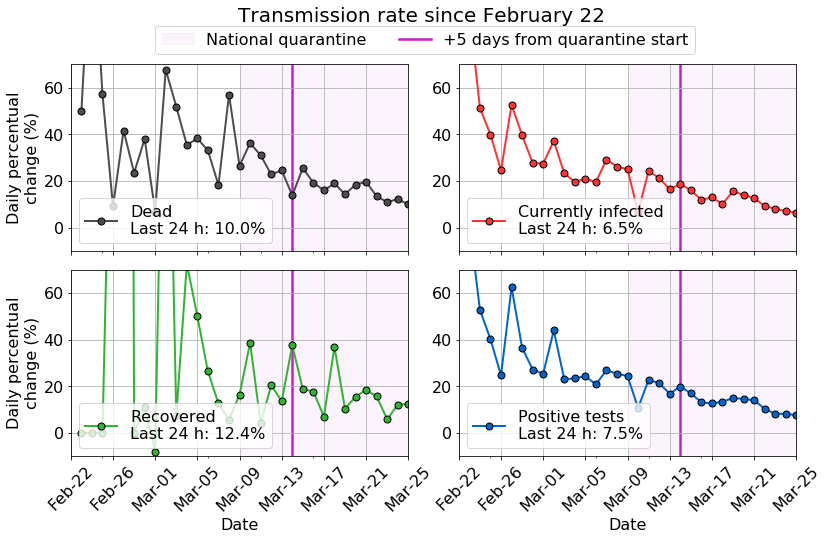

In [20]:
xini = '2020-02-22'
labels = ['Dead\nLast 24 h: {:.1f}%'.format(covid.Dead_perc[-1]),
          'Currently infected\nLast 24 h: {:.1f}%'.format(covid.Infected_perc[-1]), 
          'Recovered\nLast 24 h: {:.1f}%'.format(covid.Recovered_perc[-1]),
          'Positive tests\nLast 24 h: {:.1f}%'.format(covid.Total_perc[-1])]
dates = pd.date_range(xini, xfin, freq='4D')
dateticks = [t.strftime('%b-%d') for t in dates]

fig, axs = plt.subplots(figsize=(13,8), nrows=2, ncols=2, sharex=True, sharey=False, gridspec_kw={'hspace': 0.1, 'wspace': 0.15})
covid.plot(y=['Dead_perc'], ax=axs[0,0], grid=True, color=colors[1], marker='o', markersize=7, linewidth=2, markeredgecolor='k', markeredgewidth=1, xticks=[], x_compat=True)
covid.plot(y=['Infected_perc'], ax=axs[0,1], grid=True, color=colors[0], marker='o', markersize=7, linewidth=2, markeredgecolor='k', markeredgewidth=1, xticks=[], x_compat=True)
covid.plot(y=['Recovered_perc'], ax=axs[1,0], grid=True, color=colors[2], marker='o', markersize=7, linewidth=2, markeredgecolor='k', markeredgewidth=1, xticks=[], x_compat=True)
covid.plot(y=['Total_perc'], ax=axs[1,1], grid=True, color=colors[3], marker='o', markersize=7, linewidth=2, markeredgecolor='k', markeredgewidth=1, xticks=[], x_compat=True)
fig.suptitle('Transmission rate since February 22', fontsize=Z+4)
for ax in axs[:,0]:
    ax.set_ylabel("Daily percentual\nchange (%)", fontsize=Z)
for ax, lab in zip(axs.flatten(), labels):
    quarspan = ax.axvspan(xmin=xquarini, xmax=xfin, color=c_span, alpha=0.1, zorder=0)
    quar = ax.axvline(xplus5, c=c_5, lw=2.5, zorder=1)
    ax.set_xlim(xini, xfin)
    ax.set_xticks(dates)
    ax.set_xticklabels(dateticks, rotation=45)
    ax.set_ylim(-10, 70)
    ax.tick_params(labelsize=Z)
    ax.set_xlabel("Date", fontsize=Z)
    legend1 = plt.legend([quarspan, quar], ['National quarantine', '+5 days from quarantine start'], loc='upper center', bbox_to_anchor=(-0.1,2.35), fontsize=Z, ncol=2)
    ax.legend([lab], fontsize=Z, loc='lower left')
plt.gca().add_artist(legend1)
plt.savefig("Transmission.png", dpi=300, format='png', bbox_inches='tight')
plt.show()
plt.close()

[ 0  4  8 12 16 20 24 28 32]
['Feb-22', 'Feb-26', 'Mar-01', 'Mar-05', 'Mar-09', 'Mar-13', 'Mar-17', 'Mar-21', 'Mar-25']


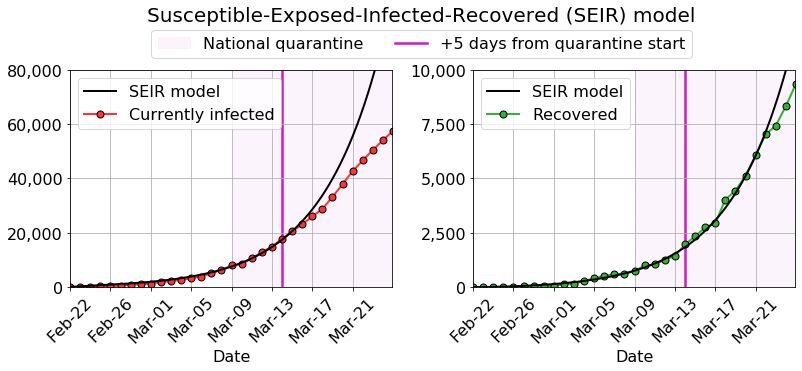

In [26]:
smooth_times = np.arange(0, len(covid)-1, dh)
infected = pred_infected(smooth_times, *popt)
recovered = pred_recovered(smooth_times, *popt)
xini = '2020-02-22'
dates = pd.date_range(xini, xfin, freq='4D')
days = np.arange(0, len(covid), 4)
print(days)
dateticks = [t.strftime('%b-%d') for t in dates]
print(dateticks)

fig, axs = plt.subplots(figsize=(13,4), ncols=2, nrows=1, gridspec_kw={'wspace': 0.25})
fig.suptitle('Susceptible-Exposed-Infected-Recovered (SEIR) model\n', fontsize=Z+4, y=1.1)
axs[0].plot(smooth_times, infected*10**6, label="SEIR model", lw=2, c='k', zorder=3)
axs[0].errorbar(range(len(covid.index)), covid['Infected'], label="Currently infected", color=colors[0], fmt='o-', markersize=7, linewidth=2, markeredgecolor='k', markeredgewidth=1, zorder=2)
axs[1].plot(smooth_times, recovered*10**6, label="SEIR model", lw=2, c='k', zorder=3)
axs[1].errorbar(range(len(covid.index)), covid['Recovered'], label="Recovered", color=colors[2], fmt='o-', markersize=7, linewidth=2, markeredgecolor='k', markeredgewidth=1, zorder=2)

axs[0].set_ylim(0, top_cases)
axs[0].set_yticks(np.linspace(0, top_cases, 5))
axs[1].set_ylim(0, top_cases//8)
axs[1].set_yticks(np.linspace(0, top_cases//8, 5))
for ax in axs.flatten():
    quarspan = ax.axvspan(xmin=int(np.where(covid.index==xquarini)[0]), xmax=len(covid)-1, color=c_span, alpha=0.1, zorder=0)
    quar = ax.axvline(int(np.where(covid.index==xplus5)[0]), c=c_5, lw=2.5, zorder=1)
    ax.set_xticks(days)
    ax.set_xticklabels(dateticks, rotation=45)
    ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.set_xlim(0,max(smooth_times))
    ax.grid()
    ax.tick_params(labelsize=Z)
    ax.set_xlabel("Date", fontsize=Z)
    legend1 = plt.legend([quarspan, quar], ['National quarantine', '+5 days from quarantine start'], loc='upper center', bbox_to_anchor=(-0.16,1.22), fontsize=Z, ncol=2)
    ax.legend(fontsize=Z, loc='upper left')
plt.gca().add_artist(legend1)
plt.savefig("SEIR.png", dpi=300, format='png', bbox_inches='tight')
plt.show()
plt.close()